In [1]:
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from pathlib import Path
import numpy as np
import math

In [2]:

#######################################################################
#        Yingyao Zhou, yzhou@gnf.org
#        August 7, 2013
#        Last modified 8/7/13
#######################################################################

def error_msg(s_msg):
    print("ERROR> ", s_msg)
    exit()

def lnbinomial(n, k):
    return math.lgamma(n+1)-math.lgamma(n-k+1)-math.lgamma(k+1)

def hyper(n, N, n1, n2, tolerance=1e-300, n_chunk=1000):
    '''N M_total: total number of objects in bin
    n1 n_white: total number of white objects in bin
    n2 N_pick: number of draws without replacement
    n x_white: x out of N_pick are white'''
    n_chunk=1000 if n_chunk<=0 else n_chunk
    min_idx=min(n1,n2)
    l_left=n*1.0/n1 < n2*1.0/N and n<min_idx-n+1
    term=1.0
    P=0.0 if l_left else 1.0 #when l_left, do not include pvalue2(N,n1,n2,n) itself
    if l_left:
        for x in range(n-1,-1,-n_chunk):
            ## vectorize in chunks of 1000
            ## in case N is huge, we stop when the remaining area is too small
            if term*(x+1)<tolerance: break # no need to run, too small already
            X=np.arange(x, max(-1, x-n_chunk), -1.0)
            X=(X+1)*(N-n1-n2+1+X)/(n1-X)/(n2-X)
            X=X.cumprod()*term
            term=X[-1]
            P+=X.sum()
    else:
        for x in range(n+1, min_idx+1, n_chunk):
            if term*(min_idx-x+1)<tolerance: break
            X=np.arange(x, min(min_idx+1, x+n_chunk), 1.0)
            X=(1+n1-X)*(1+n2-X)/X/(X+N-n1-n2)
            X=X.cumprod()*term
            term=X[-1]
            P+=X.sum()
    P*=math.exp(lnbinomial(n2,n)+lnbinomial(N-n2,n1-n)-lnbinomial(N,n1))
    return 1.0-P if l_left else P

def hyper_previous(n, N, n1, n2):
    '''N M_total: total number of objects in bin
    n1 n_white: total number of white objects in bin
    n2 N_pick: number of draws without replacement
    n x_white: x out of N_pick are white'''
    min_idx=min(n1,n2)
    l_left=n*1.0/n1 < n2*1.0/N and n<min_idx-n+1
    term=1.0
    P=0.0 if l_left else 1.0 #when l_left, do not include pvalue2(N,n1,n2,n) itself
    if l_left:
        for x in range(n-1,-1,-1):
            term*=(x+1.0)*(N-n2-n1+x+1.0)/(n1-x)/(n2-x)
            P+=term
    else:
        for x in range(n+1, min_idx+1):
            term*=(n1-x+1.0)*(n2-x+1.0)/x/(N-n2-n1+x)
            P+=term
    P*=math.exp(lnbinomial(n2,n)+lnbinomial(N-n2,n1-n)-lnbinomial(N,n1))
    return 1.0-P if l_left else P

def hyper_(x_white, M_total, n_white, N_pick):
    """This version is too slow"""
    '''M_total: total number of objects in bin
    n_white: total number of white objects in bin
    N_pick: number of draws without replacement
    x_white: x out of N_pick are white'''
    return ss.hypergeom.sf(x_white-1, M_total, n_white, N_pick)

def RSA_score(I_rank,N,i_min=None,i_max=None,l_BonferroniCorrection=False):
    cutoff=0
    logP_min=1.0
    n=len(I_rank);
    if i_max is None: i_max=n-1
    if i_min is None: i_min=0
    i_scale=(i_max-i_min+1) if l_BonferroniCorrection else 1
    for i in range(i_min,i_max+1):
        #print i, N, n, I_rank[i]
        #print ">>>>>>>", hyper(i+1, N, n, I_rank[i])*i_scale
        if (i<i_max) and (I_rank[i]==I_rank[i+1]): continue
        logP=math.log(max(hyper(i+1, N, n, I_rank[i]+1)*i_scale, 1e-100), 10)
        if (logP < logP_min):
            logP_min=logP
            cutoff=i
    return {'logP':logP_min, 'cutoff':cutoff}

def RSA(T, s_gene="GeneID", s_score="Score", l_reverse=False, LB=0.2, UB=0.8, l_randomize=False, l_BonferroniCorrection=False):
    t=T.copy()
    S=list(t.columns.values)
    #S=util.header(t)
    if t[s_gene].dtype is not np.dtype(object):
        t[s_gene]=t[s_gene].astype(str)
    t=t[ (pd.notnull(t[s_gene])) & (t[s_gene]!="") & (pd.notnull(t[s_score])) ]
    N=len(t)
    R_logP=np.zeros(N)
    R_bestActivity=np.zeros(N)
    I_hit=np.zeros(N).astype(int)
    I_totWell=np.zeros(N).astype(int)
    I_hitWell=np.zeros(N).astype(int)
    if l_randomize:
        R=t[s_score].values
        R=R[np.random.permutation(len(R))]
        t[s_score]=R
    t.sort_values(by=s_score, ascending=(not l_reverse), inplace=True)
    c_gene=dict()
    c_rank=dict()
    # we need to hash the max rank of a given score.
    # if t is a membership matrix, there are lots of ties, obtaining
    # c_rank can be the bottleneck
    c_score=dict()
    R_score=t[s_score].values
    for i in range(N):
        c_score[R_score[i]]=i

    for i in range(len(t)):
        #s=t.irow(i)[s_gene]
        s=t.iloc[i][s_gene]
        if s not in c_gene:
            c_gene[s]=[] # store the exact index for this gene
            c_rank[s]=[] # modify the rank, in case there are ties
        # updated on 10/19/2012
        c_gene[s].append(i)
        # the following can be the slowest part, if there are lots of ties
        #for j in range(i+1, N):
        #    if t[s_score].iloc[j]!=t[s_score].iloc[i]: break
        #c_rank[s].append(j-1)
        c_rank[s].append(c_score[R_score[i]])
    for s in c_gene:
        #if s!='19218': continue
        I_rank=c_rank[s]
        i_max=None
        i_min=None
        for k in range(len(I_rank)):
            if l_reverse:
                if R_score[I_rank[k]]>=LB: i_max=k
                if R_score[I_rank[k]]>=UB: i_min=k
                if (R_score[I_rank[k]]<LB and i_max is None): i_max=k-1
            else:
                if R_score[I_rank[k]]<=UB: i_max=k
                if R_score[I_rank[k]]<=LB: i_min=k
                if (R_score[I_rank[k]]>UB and i_max is None): i_max=k-1
        rslt=RSA_score(I_rank,N,i_min,i_max,l_BonferroniCorrection=l_BonferroniCorrection)
        logP=rslt['logP']
        cutoff=rslt['cutoff']
        I_idx=c_gene[s]
        for k in range(len(I_idx)):
            R_logP[I_idx[k]]=logP
            R_bestActivity[I_idx[k]]=R_score[I_idx[0]]
            I_hitWell[I_idx[k]]=cutoff+1
            I_totWell[I_idx[k]]=len(I_idx)
            if (k<=cutoff): I_hit[I_idx[k]]=1

    t["LogP"]=R_logP
    t["BestActivity"]=R_bestActivity
    t["RSA_Hit"]=I_hit
    t["#hitWell"]=I_hitWell
    t["#totalWell"]=I_totWell
    # q-value
    t_p=t.drop_duplicates([s_gene,'LogP'])
    Rq=np.log10(adjust_p(np.power(10, t_p.LogP.clip(-np.inf, 0))))
    t_q=pd.DataFrame({s_gene: t_p[s_gene], 'Log_q':Rq})
    t=t.merge(t_q, left_on=[s_gene], right_on=[s_gene])
    ###
    t.sort_values(by=['LogP',s_gene,s_score], ascending=[True, True, not l_reverse], inplace=True)
    #t["LogP"]=util.rarray2sarray(t["LogP"], s_format='%.4f')
    t["RSA_Rank"]=np.zeros(N).astype(int)+999999
    cnt=0
    for k in range(N):
        if t["RSA_Hit"].values[k]>0:
            cnt+=1
            t["RSA_Rank"].values[k]=cnt
    return t

def adjust_p(R_p, N=None, method="BH"):
    """Calculate FDR for multiple test. N is the total # of tests run, if not given, set to len(R_p)
    R_p: an array of p-values
    N: int, total number of tests run
    method: currently fixed to Benjamini and Hochberg method.
    Output has been valided with adjust.p in R"""
    l_old=False # old implementation, slower, keep in case there is bug, new code has been tested
    N=len(R_p) if N is None else N
    if method.upper()=="BONFERRONI":
        return np.clip(np.array(R_p)*N, 0.0, 1.0)
    elif method.upper()=="HOLM":
        n=len(R_p)
        t=pd.DataFrame({'p':R_p, 'q':R_p, 'I':list(range(len(R_p)))})
        t.sort_values('p', ascending=True, inplace=True)
        t.index=range(n)
        if l_old:
            q=0.0
            for i in range(n):
                q=t.ix[i, 'q']=min(max(q, t.ix[i, 'p']*(N-i)),1)
        else:
            q=np.clip(t.p.values*(N-np.arange(n)), 0.0, 1.0)
            q=np.maximum.accumulate(q)
            t['q']=q
        t.sort_values('I', inplace=True)
        return t.q.values
    elif method.upper() in ("BH","FDR"):
        n=len(R_p)
        t=pd.DataFrame({'p':R_p, 'q':R_p, 'I':list(range(len(R_p)))})
        t.sort_values('p', ascending=False, inplace=True)
        t.index=range(n)
        if l_old:
            q=1.0
            for i in range(n):
                q=t.ix[i, 'q']=min(q, t.ix[i, 'p']*N*1.0/(len(t)-i))
        else:
            q=np.clip(t.p.values*N*1.0/(n-np.arange(n)), 0.0, 1.0)
            q=np.minimum.accumulate(q)
            t['q']=q
        t.sort_values('I', inplace=True)
        return t.q.values
    else:
        util.error_msg('Unsupported method: %s' % method)

In [3]:
metabolites_rnaseq_combined = pd.read_csv("./metabolite_rnaseq_correlation_matrix.csv", index_col = "Unnamed: 0")

In [4]:
zscore_dataframe = pd.DataFrame(stats.zscore(metabolites_rnaseq_combined.transpose())).transpose()
zscore_dataframe.columns = metabolites_rnaseq_combined.columns
zscore_dataframe.index = metabolites_rnaseq_combined.index

C:\Users\ds728\anaconda3\lib\site-packages\scipy\stats\stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [5]:
zscore_dataframe_metabolites = zscore_dataframe.head(1099)

In [6]:
zscore_dataframe_metabolites

,SHP77,PC9,LUDLU1,NCIH446,MALME3M,NCIH1755,HCC1187,CORL88,NCIH2171,NCIH1155,...,NCIH526,NCIH146,HL60,NCIH82,SF268,SF539,K562,DU4475,UO31,EKVX
1,0.775782,1.376763,1.177605,1.679806,0.378006,1.916782,2.678167,-0.014645,-0.218838,-1.834040,...,-0.856683,1.072496,-1.482120,0.158258,-0.877183,-1.469532,0.427099,-0.682611,-0.494872,-0.549000
2,1.505271,2.122538,-0.735373,2.862532,-0.971666,-0.869158,0.622574,2.709133,-1.394612,-1.064992,...,0.394029,0.595009,-1.193228,-1.453332,-0.360251,-1.233787,-1.579651,-2.350679,-0.571118,-0.436123
3,0.646809,1.984327,0.547110,1.945590,0.650913,1.761409,3.041286,0.199699,0.112183,2.592212,...,-0.753615,-1.154603,-0.971340,-1.127397,0.760511,1.521197,-0.884878,-1.351474,-1.319922,-0.395378
4,-0.471229,0.819520,-0.186991,0.455024,-0.230821,0.823719,1.008907,-0.918713,-0.225309,1.309784,...,-0.125839,-0.293635,-1.118965,-1.244068,0.609732,1.443811,-0.437810,0.665022,-1.065775,-1.077148
5,0.334760,4.225992,1.277785,0.595728,-0.204668,1.068505,1.273144,1.165229,0.422665,-2.634772,...,0.040395,-0.990317,-0.896629,-0.338983,-0.362405,-0.824628,-1.035282,-1.176537,-0.338405,-1.105548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0.386287,-0.213819,4.611393,1.572735,2.871780,0.223372,0.406549,-0.265633,-0.820499,0.690981,...,0.134954,1.097238,-1.466104,1.467149,-1.058041,-1.575144,1.436989,0.896687,-1.370726,0.529612
1096,-1.315613,-0.928867,0.011669,-0.279570,-0.090261,-0.241682,-0.223328,-0.942086,0.706502,1.810040,...,0.540113,1.804577,1.575588,2.715725,-0.571837,1.422419,1.016664,0.603479,0.299544,-0.758655
1097,0.339201,-0.026889,0.892945,0.034256,-0.187962,0.434001,-0.358977,0.428238,-0.890822,-0.757267,...,0.134761,-0.249625,-0.658937,-0.815832,-0.464438,-0.853867,-0.642224,-0.767424,-0.797103,-0.139986
1098,-0.725976,-0.146492,1.365924,1.061939,0.897581,0.419725,0.767716,-0.031596,0.662658,2.050792,...,-0.144239,1.699347,0.828493,2.201483,-0.614585,-1.033616,2.046286,1.640022,-0.349499,-1.032364


In [7]:
dorothea_scores = pd.read_csv("../../Transcriptionfactor_correlations/TF_activities_AB.csv", index_col = "Unnamed: 0").transpose()

In [8]:
newindex = []
for item in dorothea_scores.index:
    newitem = item.split("_")[0]
    if newitem == "X786O":
        newitem = "786O"
    if newitem == "X5637":
        newitem = "5637"
    if newitem == "X769P":
        newitem = "769P"
    if newitem == "X647V":
        newitem = "647V"
    newindex.append(newitem)
dorothea_scores.index = newindex

In [9]:
pathway_annotations = pd.read_csv("../../Metabolic_pathways/Core_Metabolic_pathways_SMPDB.csv")
metabolite_reference = pd.read_csv("../../AZ_data/Metabolite_reference_table.csv")

In [14]:
master_pathwaylist = []
master_correlationlist = []
for pathwaytop in dorothea_scores.columns:
    print(pathwaytop)
    score_values = pd.DataFrame(dorothea_scores[pathwaytop]).transpose()
    combined_dataframe = pd.concat([score_values, zscore_dataframe_metabolites], axis =0, join="inner")
    correlation = pd.DataFrame(combined_dataframe.transpose().corr().sort_values(by  =pathwaytop, ascending = False)[pathwaytop])
    correlation = correlation.drop(pathwaytop, axis = 0)
    
    pathway_scores = []
    pathway_correlation = []
    
    ## Calculate the integers for the metabolites in each pathway
    for index, row in pathway_annotations.iterrows():
        pathwayid, pathwayname = row["Pathway ID"], row["Pathway name"]
        pathwayname = pathwayname.replace("/", "_")
        # find the appropriate pathway file
        pathwayfile = ("../../Metabolic_pathways/SMPDB_pathways/" + pathwayid + "_metabolites.csv")
        if Path(pathwayfile).is_file():
            pathway = pd.read_csv(pathwayfile)
            # Remove nans from metabolite ids
            metabolite_ids = pathway["HMDB ID"][~pathway["HMDB ID"].isnull()].tolist()
            ## We have to transform the metabolite ids because they dont match
            new_metabolite_ids = []
            for item in metabolite_ids:
                newid = "HMDB" + item.split("HMDB")[1][2:]
                new_metabolite_ids.append(newid)
            #subset the cell values by this pathway only
            metabolite_idarray = metabolite_reference[metabolite_reference["id"].isin(new_metabolite_ids)]
            metabolite_idlist = metabolite_idarray["ionIdx"].tolist()
        
            correlation["Pathway"] = np.where(correlation.index.astype(int).isin(metabolite_idlist), "path", "nopath")
            if len(correlation["Pathway"].unique()) == 1:
                continue
            ## RSA statistic calculation
            RSAarray =RSA(correlation, s_gene="Pathway", s_score=pathwaytop, l_reverse = True, LB = -1, UB = 1)
            correlation_value = correlation[correlation["Pathway"] == "path"][pathwaytop].mean()
            
            log_qvalue = RSAarray[RSAarray["Pathway"] == "path"]["Log_q"].iloc[0]
            pathway_scores.append([pathwayname, log_qvalue])
            pathway_correlation.append([pathwayname, correlation_value])
            
    pathway_values = (pd.DataFrame(pathway_scores, columns=["Pathway", "Score_" + pathwaytop]))
    pathway_values = pathway_values.set_index("Pathway")
    master_pathwaylist.append(pathway_values)
    
    correlation_values = (pd.DataFrame(pathway_correlation, columns=["Pathway", "Correlation_" + pathwaytop]))
    correlation_values = correlation_values.set_index("Pathway")
    master_correlationlist.append(correlation_values)

AR
ARNTL
ATF1
ATF2
ATF4
BACH1
CDX2
CEBPA
CEBPB
CEBPD
CREB1
CTCF
E2F1
E2F2
E2F3
E2F4
EGR1
ELK1
EPAS1
ERG
ESR1
ESR2
ETS1
ETS2
ETV4
FLI1
FOS
FOSL1
FOSL2
FOXA1
FOXL2
FOXM1
FOXO1
FOXO3
FOXO4
FOXP1
GATA1
GATA2
GATA3
GLI2
HIF1A
HNF1A
HNF4A
IRF1
IRF9
JUN
JUND
KLF4
KMT2A
LEF1
MITF
MYB
MYC
MYCN
NFATC2
NFE2L2
NFIC
NFKB1
NFKB2
NR2F2
NR5A1
PAX6
PAX8
PGR
POU2F1
PPARA
PPARG
PRDM14
RARA
REL
RELA
RELB
REST
RFX5
RUNX1
RXRA
SMAD3
SMAD4
SOX10
SOX2
SOX9
SP1
SP3
SPI1
SREBF1
SREBF2
SRF
STAT1
STAT2
STAT3
STAT5A
STAT5B
STAT6
TAL1
TCF7L2
TFAP2A
TFAP2C
TP53
TP63
TWIST1
USF1
USF2
VDR
WT1
YY1
ZNF263


In [39]:
master_pathwaylist_reverse = []
master_correlationlist_reverse = []
for pathwaytop in dorothea_scores.columns:
    print(pathwaytop)
    score_values = pd.DataFrame(dorothea_scores[pathwaytop]).transpose()
    combined_dataframe = pd.concat([score_values, zscore_dataframe_metabolites], axis =0, join="inner")
    correlation = pd.DataFrame(combined_dataframe.transpose().corr().sort_values(by  =pathwaytop, ascending = False)[pathwaytop])
    correlation = correlation.drop(pathwaytop, axis = 0)
    
    pathway_scores = []
    pathway_correlation = []
    
    ## Calculate the integers for the metabolites in each pathway
    for index, row in pathway_annotations.iterrows():
        pathwayid, pathwayname = row["Pathway ID"], row["Pathway name"]
        pathwayname = pathwayname.replace("/", "_")
        # find the appropriate pathway file
        pathwayfile = ("../../Metabolic_pathways/SMPDB_pathways/" + pathwayid + "_metabolites.csv")
        if Path(pathwayfile).is_file():
            pathway = pd.read_csv(pathwayfile)
            # Remove nans from metabolite ids
            metabolite_ids = pathway["HMDB ID"][~pathway["HMDB ID"].isnull()].tolist()
            ## We have to transform the metabolite ids because they dont match
            new_metabolite_ids = []
            for item in metabolite_ids:
                newid = "HMDB" + item.split("HMDB")[1][2:]
                new_metabolite_ids.append(newid)
            #subset the cell values by this pathway only
            metabolite_idarray = metabolite_reference[metabolite_reference["id"].isin(new_metabolite_ids)]
            metabolite_idlist = metabolite_idarray["ionIdx"].tolist()
        
            correlation["Pathway"] = np.where(correlation.index.astype(int).isin(metabolite_idlist), "path", "nopath")
            if len(correlation["Pathway"].unique()) == 1:
                continue
            ## RSA statistic calculation
            RSAarray =RSA(correlation, s_gene="Pathway", s_score=pathwaytop, l_reverse = False, LB = -1, UB = 1)
            correlation_value = correlation[correlation["Pathway"] == "path"][pathwaytop].mean()
            
            log_qvalue = RSAarray[RSAarray["Pathway"] == "path"]["Log_q"].iloc[0]
            pathway_scores.append([pathwayname, log_qvalue])
            pathway_correlation.append([pathwayname, correlation_value])
            
    pathway_values = (pd.DataFrame(pathway_scores, columns=["Pathway", "Score_" + pathwaytop]))
    pathway_values = pathway_values.set_index("Pathway")
    master_pathwaylist_reverse.append(pathway_values)
    
    correlation_values = (pd.DataFrame(pathway_correlation, columns=["Pathway", "Correlation_" + pathwaytop]))
    correlation_values = correlation_values.set_index("Pathway")
    master_correlationlist_reverse.append(correlation_values)

AR
ARNTL
ATF1
ATF2
ATF4
BACH1
CDX2
CEBPA
CEBPB
CEBPD
CREB1
CTCF
E2F1
E2F2
E2F3
E2F4
EGR1
ELK1
EPAS1
ERG
ESR1
ESR2
ETS1
ETS2
ETV4
FLI1
FOS
FOSL1
FOSL2
FOXA1
FOXL2
FOXM1
FOXO1
FOXO3
FOXO4
FOXP1
GATA1
GATA2
GATA3
GLI2
HIF1A
HNF1A
HNF4A
IRF1
IRF9
JUN
JUND
KLF4
KMT2A
LEF1
MITF
MYB
MYC
MYCN
NFATC2
NFE2L2
NFIC
NFKB1
NFKB2
NR2F2
NR5A1
PAX6
PAX8
PGR
POU2F1
PPARA
PPARG
PRDM14
RARA
REL
RELA
RELB
REST
RFX5
RUNX1
RXRA
SMAD3
SMAD4
SOX10
SOX2
SOX9
SP1
SP3
SPI1
SREBF1
SREBF2
SRF
STAT1
STAT2
STAT3
STAT5A
STAT5B
STAT6
TAL1
TCF7L2
TFAP2A
TFAP2C
TP53
TP63
TWIST1
USF1
USF2
VDR
WT1
YY1
ZNF263


In [45]:
RSAarray

,ZNF263,Pathway,LogP,BestActivity,RSA_Hit,#hitWell,#totalWell,Log_q,RSA_Rank
0,-0.248307,nopath,-6.968788,-0.248307,1,480,1066,-6.667758,1
1,-0.248005,nopath,-6.968788,-0.248307,1,480,1066,-6.667758,2
2,-0.243361,nopath,-6.968788,-0.248307,1,480,1066,-6.667758,3
3,-0.240570,nopath,-6.968788,-0.248307,1,480,1066,-6.667758,4
4,-0.234049,nopath,-6.968788,-0.248307,1,480,1066,-6.667758,5
...,...,...,...,...,...,...,...,...,...
1094,0.140600,path,-0.564937,-0.045523,1,32,33,-0.564937,509
1095,0.141894,path,-0.564937,-0.045523,1,32,33,-0.564937,510
1096,0.150863,path,-0.564937,-0.045523,1,32,33,-0.564937,511
1097,0.154340,path,-0.564937,-0.045523,1,32,33,-0.564937,512


In [15]:
combined_dataframe = pd.concat(master_pathwaylist, axis =1)

In [40]:
combined_dataframe_reverse = pd.concat(master_pathwaylist_reverse, axis =1)

In [16]:
combined_correlation_dataframe = pd.concat(master_correlationlist, axis =1)

In [41]:
combined_correlation_dataframe_reverse = pd.concat(master_correlationlist_reverse, axis =1)

In [60]:
combined_dataframe_reverse

,Score_AR,Score_ARNTL,Score_ATF1,Score_ATF2,Score_ATF4,Score_BACH1,Score_CDX2,Score_CEBPA,Score_CEBPB,Score_CEBPD,...,Score_TFAP2C,Score_TP53,Score_TP63,Score_TWIST1,Score_USF1,Score_USF2,Score_VDR,Score_WT1,Score_YY1,Score_ZNF263
Pathway,,,,,,,,,,,,,,,,,,,,,
Alanine Metabolism,-0.351586,-1.408938,-0.598998,-0.201917,-0.612376,-0.989991,-0.961155,-0.641485,-0.693408,-0.134357,...,-0.726579,-0.257341,-0.400912,-0.635612,-0.319709,-0.505954,-0.232678,-0.571711,-1.749717,-0.178943
Alpha Linolenic Acid and Linoleic Acid Metabolism,-0.802287,-0.552512,-1.788944,-2.468682,-1.093089,-0.668320,-2.975368,-3.247980,-4.621442,-4.171245,...,-1.263440,-2.832678,-1.056934,-0.637389,-1.214045,-1.324173,-0.678294,-0.192365,-0.160163,-0.865870
Amino Sugar Metabolism,-0.730641,-1.481696,-1.840963,-0.283621,-0.704543,-2.061504,-0.031949,-1.331851,-0.605854,-0.300111,...,-0.090088,-0.328282,-0.690486,-0.688290,-0.704543,-2.350652,-0.136603,-2.031306,-2.141978,-0.267698
Ammonia Recycling,-1.360835,-1.009507,-1.025849,-0.269314,-1.038972,-2.485986,-0.030338,-1.890595,-0.395419,-1.077525,...,-0.068417,-1.292264,-1.177934,-1.076997,-0.831232,-0.701467,-0.503756,-1.470119,-2.861406,-0.308515
Androgen and Estrogen Metabolism,-1.253063,-1.677665,-1.064874,-0.284712,-1.441181,-0.424144,-0.532538,-1.825291,-0.293690,-0.304558,...,-1.426005,-0.773074,-1.769403,-1.225416,-0.734669,-0.704505,-0.367990,-1.742301,-1.109943,-0.214344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Urea Cycle,-1.207950,-0.912056,-0.439402,-0.226472,-0.580783,-2.240510,-0.729048,-1.053532,-0.316684,-1.149784,...,-0.508954,-1.365705,-0.845167,-0.549576,-0.389684,-0.759422,-0.397381,-0.920767,-1.876244,-0.674721
"Valine, Leucine, and Isoleucine Degradation",-1.312415,-2.556772,-0.609696,-0.152988,-0.222816,-1.662651,-0.106944,-2.482705,-1.013775,-0.212489,...,-0.383706,-1.170036,-1.325608,-0.912669,-1.395484,-2.044299,-0.566645,-1.202247,-1.343770,-0.103354
Vitamin B6 Metabolism,-0.980048,-0.632229,-0.677734,-0.615009,-0.475348,-0.960396,-0.569597,-0.700858,-0.376441,-1.266805,...,-0.519175,-1.486675,-0.927593,-0.580583,-1.262097,-1.166885,-0.328513,-1.442005,-0.402540,-0.331189


In [18]:
combined_dataframe.to_csv("TF_pathway_correlations_log10qvalue_noMCF7_v1.csv")

In [42]:
combined_dataframe_reverse.to_csv("TF_pathway_correlations_reverse_log10qvalue_noMCF7_v1.csv")

In [19]:
combined_correlation_dataframe.to_csv("TF_pathway_correlations_mean_noMCF7_v1.csv")

In [43]:
combined_correlation_dataframe_reverse.to_csv("TF_pathway_correlations_reverse_mean_noMCF7_v1.csv")

In [44]:
combined_correlation_dataframe_reverse

,Correlation_AR,Correlation_ARNTL,Correlation_ATF1,Correlation_ATF2,Correlation_ATF4,Correlation_BACH1,Correlation_CDX2,Correlation_CEBPA,Correlation_CEBPB,Correlation_CEBPD,...,Correlation_TFAP2C,Correlation_TP53,Correlation_TP63,Correlation_TWIST1,Correlation_USF1,Correlation_USF2,Correlation_VDR,Correlation_WT1,Correlation_YY1,Correlation_ZNF263
Pathway,,,,,,,,,,,,,,,,,,,,,
Alanine Metabolism,0.015013,-0.022631,-0.006052,0.044470,0.016541,-0.032890,0.114108,-0.022209,-0.012660,0.050739,...,0.082774,0.006848,-0.045600,-0.002180,-0.011149,-0.029694,0.048838,-0.013330,-0.051022,0.073506
Alpha Linolenic Acid and Linoleic Acid Metabolism,-0.053939,-0.001450,-0.101416,-0.147913,-0.032026,-0.047814,-0.195598,-0.153308,-0.173978,-0.180531,...,-0.150039,-0.157693,-0.086472,-0.017447,-0.086273,-0.068123,-0.052007,0.087203,0.043273,-0.062647
Amino Sugar Metabolism,-0.025047,-0.016928,-0.078927,0.052456,0.028413,-0.054772,0.175873,-0.043877,0.004357,0.007991,...,0.163062,-0.000638,-0.028132,0.031215,-0.033039,-0.064970,0.095937,-0.043946,-0.054663,0.070055
Ammonia Recycling,-0.045560,-0.015478,-0.041597,0.046971,0.032737,-0.024028,0.176911,-0.048847,0.011897,0.016939,...,0.164366,-0.010326,-0.015761,0.019773,-0.050398,-0.059951,0.067581,-0.048533,-0.067972,0.061985
Androgen and Estrogen Metabolism,-0.063517,-0.027990,-0.054902,0.010128,0.037347,0.052588,0.073894,-0.055455,0.035157,0.005053,...,0.097159,-0.044333,-0.048424,-0.012438,-0.056327,-0.040969,0.030910,-0.049386,-0.041451,0.058655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Urea Cycle,-0.032851,-0.015513,-0.023640,0.065198,0.049607,-0.030568,0.164770,-0.027024,0.027434,0.047109,...,0.144225,-0.002411,-0.008567,0.027049,-0.031643,-0.044226,0.069819,-0.035963,-0.044426,0.048802
"Valine, Leucine, and Isoleucine Degradation",-0.051922,-0.024969,-0.030806,0.028384,0.055143,-0.040130,0.176342,-0.076844,0.010836,0.011620,...,0.131470,-0.029208,-0.028723,0.023160,-0.083469,-0.080829,0.069605,-0.046167,-0.034042,0.097885
Vitamin B6 Metabolism,-0.040297,-0.002546,-0.047875,-0.046690,0.035347,0.041374,0.036630,-0.043448,-0.025572,-0.055949,...,0.062181,-0.065500,-0.012285,0.008089,-0.078949,-0.068328,-0.035542,-0.051048,0.033082,0.031844


## Do some plotting

In [20]:
correlation_scores = -combined_dataframe

In [54]:
pathway_correlation = combined_correlation_dataframe

In [55]:
pathway_correlation

,AR,ARNTL,ATF1,ATF2,ATF4,BACH1,CDX2,CEBPA,CEBPB,CEBPD,...,TFAP2C,TP53,TP63,TWIST1,USF1,USF2,VDR,WT1,YY1,ZNF263
Pathway,,,,,,,,,,,,,,,,,,,,,
Alanine Metabolism,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,...,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0
Alpha Linolenic Acid and Linoleic Acid Metabolism,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0
Amino Sugar Metabolism,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0
Ammonia Recycling,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0
Androgen and Estrogen Metabolism,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Urea Cycle,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0
"Valine, Leucine, and Isoleucine Degradation",-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0
Vitamin B6 Metabolism,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0


In [21]:
binaried = pd.DataFrame(np.where(correlation_scores > -np.log10(0.05), 1, 0))
binaried.columns = correlation_scores.columns
binaried.index = correlation_scores.index

In [22]:
binaried_nozeroes = binaried.loc[~(binaried==0).all(axis=1)]
binaried_nozeroes["sum"] = binaried_nozeroes.sum(axis =1)
top_50 = binaried_nozeroes.sort_values(by = "sum", ascending = False).head(50).index

In [23]:
top_correlations = correlation_scores.loc[top_50]

In [24]:
newcolumns = []
for item in top_correlations.columns:
    splititem = item.split("_")[1]
    newcolumns.append(splititem)

In [25]:
top_correlations.columns = newcolumns

In [26]:
plt.rcParams['figure.figsize'] = [8,18]
palette_cmap = sns.light_palette(sns.color_palette("Set3")[2], as_cmap = True)

In [27]:
labelled = (np.where(top_correlations > -np.log10(0.001), "***", ""))

In [28]:
top_correlations

,AR,ARNTL,ATF1,ATF2,ATF4,BACH1,CDX2,CEBPA,CEBPB,CEBPD,...,TFAP2C,TP53,TP63,TWIST1,USF1,USF2,VDR,WT1,YY1,ZNF263
Pathway,,,,,,,,,,,,,,,,,,,,,
Warburg Effect,1.038516,0.504639,0.711968,6.278096,3.394164,1.353584,4.404497,0.959689,2.767758,5.536358,...,8.527444,2.723683,1.443791,2.335187,1.328536,0.996943,6.960139,0.208938,0.411040,6.667758
Tyrosine Metabolism,2.202804,1.186906,2.529251,2.231152,2.736888,1.377160,0.944227,2.043530,1.708285,4.525027,...,1.584767,5.279026,1.040434,0.903337,1.632350,1.523821,0.812073,1.457169,0.997152,0.749825
Phenylalanine and Tyrosine Metabolism,1.514709,1.251214,1.896244,4.131903,2.877981,1.073943,1.413105,1.370256,2.308562,4.971063,...,1.397291,3.358071,1.970557,0.791585,1.425819,0.944295,2.446219,0.612888,0.978788,2.026830
Steroidogenesis,1.450857,1.422692,3.170214,0.812453,1.829812,2.156841,0.486869,3.664543,2.842555,2.149542,...,0.633623,2.388834,0.942126,1.231346,2.184018,2.360561,0.205052,2.234116,1.625581,0.825023
Starch and Sucrose Metabolism,0.381559,0.202007,0.754486,5.043487,3.198820,0.785682,4.415001,0.784665,1.718341,6.481700,...,5.761200,2.130164,2.565067,2.252571,1.407629,1.092023,5.284075,0.131052,0.104168,4.827697
Fatty Acid Biosynthesis,2.769364,1.106467,2.598669,0.491203,0.410150,0.787518,0.246894,4.020565,0.911368,0.644950,...,0.135185,1.158817,0.552918,0.501455,2.905757,4.987449,0.072401,3.084795,2.967893,0.516047
Pterine Biosynthesis,1.737694,0.443415,2.423003,2.384836,1.994571,2.536195,1.193228,1.854304,2.469390,3.078965,...,0.940529,2.583200,1.875100,1.974394,0.984524,1.144980,0.730178,0.558618,0.602878,0.896508
Plasmalogen Synthesis,1.975443,0.513850,1.540006,0.727503,1.836878,1.712107,0.775235,1.641831,0.647893,0.742380,...,0.757400,1.369475,1.366683,0.673325,1.115939,1.200813,1.354444,0.446402,0.704024,0.662226
Galactose Metabolism,1.004489,0.734324,1.389448,3.721994,0.750714,0.625455,2.572741,0.567240,1.003602,2.343540,...,2.158022,2.114915,2.410635,0.841270,1.795241,1.517635,2.084880,0.312566,0.711832,2.328584


In [29]:
binaried_nozeroes.sort_values(by = "sum", ascending = True).head(50)

,Score_AR,Score_ARNTL,Score_ATF1,Score_ATF2,Score_ATF4,Score_BACH1,Score_CDX2,Score_CEBPA,Score_CEBPB,Score_CEBPD,...,Score_TP53,Score_TP63,Score_TWIST1,Score_USF1,Score_USF2,Score_VDR,Score_WT1,Score_YY1,Score_ZNF263,sum
Pathway,,,,,,,,,,,,,,,,,,,,,
Vitamin B6 Metabolism,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Methylhistidine Metabolism,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
Homocysteine Degradation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
Ubiquinone Biosynthesis,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,7
Arachidonic Acid Metabolism,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
Sulfate_Sulfite Metabolism,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,8
Biotin Metabolism,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,10
Riboflavin Metabolism,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,11
Thiamine Metabolism,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,13


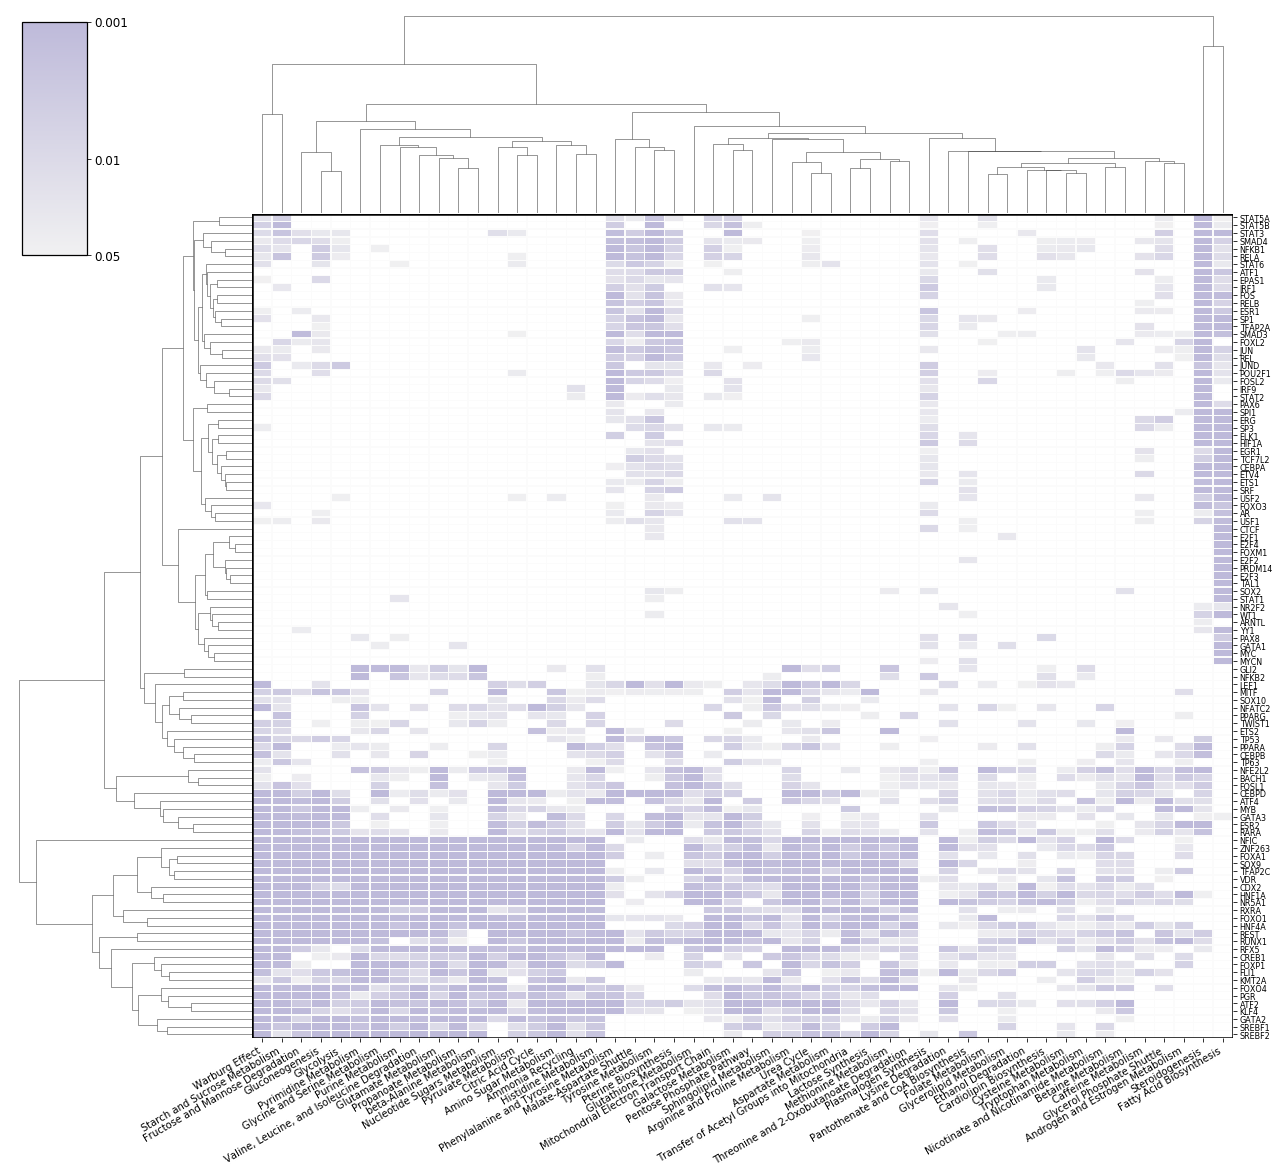

In [31]:
g = sns.clustermap(top_correlations.transpose(), cmap = palette_cmap, yticklabels = True, xticklabels = True, figsize = (18,18)
                   , mask = top_correlations.transpose()<-np.log10(0.05), vmin = -np.log10(0.05), vmax = -np.log10(0.001),
               lw = 0.25, linecolor="#fbfbfb")

ax = g.ax_heatmap
ax.set_xlabel("")
ax.axhline(0, c="k", lw = 2.5)
ax.axvline(top_correlations.shape[0], c="k", lw = 2.5)
ax.axvline(0, c="k", lw = 2.5)
ax.axhline(top_correlations.shape[1], c="k", lw = 2.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation =30, ha = "right", size = 10)

ax.set_yticklabels(ax.get_yticklabels(), rotation =0, ha = "left", size = 8)

cbar = ax.collections[0].colorbar
cbar.set_ticks([-np.log10(0.05), -np.log10(0.01), -np.log10(0.001)])
cbar.set_ticklabels(['0.05', '0.01', '0.001'])
cbar.ax.tick_params(labelsize=12)
cbar.outline.set_visible(True)
cbar.outline.set_linewidth(1.25)

plt.savefig("Clustermap_TF_metabolitepathwayassociations_noMCF7.pdf")

## Plot with direction

In [33]:
#new_columns = []
#for item in pathway_correlation.columns:
#    item = item.split("Correlation_")[1]
#    new_columns.append(item)
#    
#pathway_correlation.columns = new_columns
#correlation_scores.columns = new_columns

In [34]:
#pathway_correlation[pathway_correlation < 0] = -1
#pathway_correlation[pathway_correlation >= 0] = 1

In [56]:
complete_pathway_pvalues = correlation_scores * pathway_correlation

In [57]:
complete_pathway_pvalues

,AR,ARNTL,ATF1,ATF2,ATF4,BACH1,CDX2,CEBPA,CEBPB,CEBPD,...,TFAP2C,TP53,TP63,TWIST1,USF1,USF2,VDR,WT1,YY1,ZNF263
Pathway,,,,,,,,,,,,,,,,,,,,,
Alanine Metabolism,1.377268,-0.372744,-0.942679,2.685605,0.612376,-0.574972,1.258116,-0.641485,-0.693408,1.837982,...,1.182652,0.823053,-0.205188,-0.607716,-1.068523,-0.505954,1.256894,-0.571711,-0.249944,1.397896
Alpha Linolenic Acid and Linoleic Acid Metabolism,-0.564183,-0.552512,-0.386821,-0.079780,-0.218219,-0.296474,-0.047832,-0.145297,-0.013901,-0.060211,...,-0.205381,-0.015894,-0.172986,-0.427496,-0.704669,-0.929505,-0.319948,2.094511,0.954158,-0.182225
Amino Sugar Metabolism,-0.730641,-0.469732,-0.364449,3.387561,0.893654,-0.185921,3.856153,-0.547645,1.127094,1.449488,...,4.405555,-1.697272,-0.492730,2.035917,-1.126159,-1.442712,4.397159,-0.450828,-0.131829,3.190974
Ammonia Recycling,-0.334294,-0.301177,-0.691932,3.025817,1.323817,-1.629344,4.584281,-0.506617,1.707372,1.713226,...,3.786769,-1.341703,-1.177934,1.076997,-0.831232,-0.231332,3.612645,-0.512191,-0.071319,2.173899
Androgen and Estrogen Metabolism,-0.321988,-0.210103,-0.467566,0.769863,1.829812,2.484957,1.131642,-0.574753,2.020251,0.760206,...,2.465218,-0.773074,-1.391384,-0.456058,-0.734669,-0.704505,1.080285,-0.583996,-0.216061,1.592241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Urea Cycle,-0.546170,-0.292395,-0.632436,3.738572,2.095220,-0.990262,3.718410,-1.109441,1.208756,4.233669,...,2.903544,-1.539036,-1.118782,1.151160,-0.593058,-0.759422,3.584927,-0.411491,-0.263330,2.695731
"Valine, Leucine, and Isoleucine Degradation",-0.223274,-0.191721,-0.609696,2.636381,1.799145,-1.160271,5.211972,-0.334602,2.173942,1.889489,...,4.448554,-1.170036,-0.730227,1.221643,-0.219644,-0.285494,4.278202,-0.299416,-0.194862,7.147382
Vitamin B6 Metabolism,-0.980048,-0.632229,-0.677734,-0.449563,0.475348,0.993311,0.569597,-0.491223,-0.376441,-0.552858,...,1.149772,-0.298332,-0.927593,0.580583,-0.730178,-0.480446,-0.242670,-0.644467,1.171603,0.671368


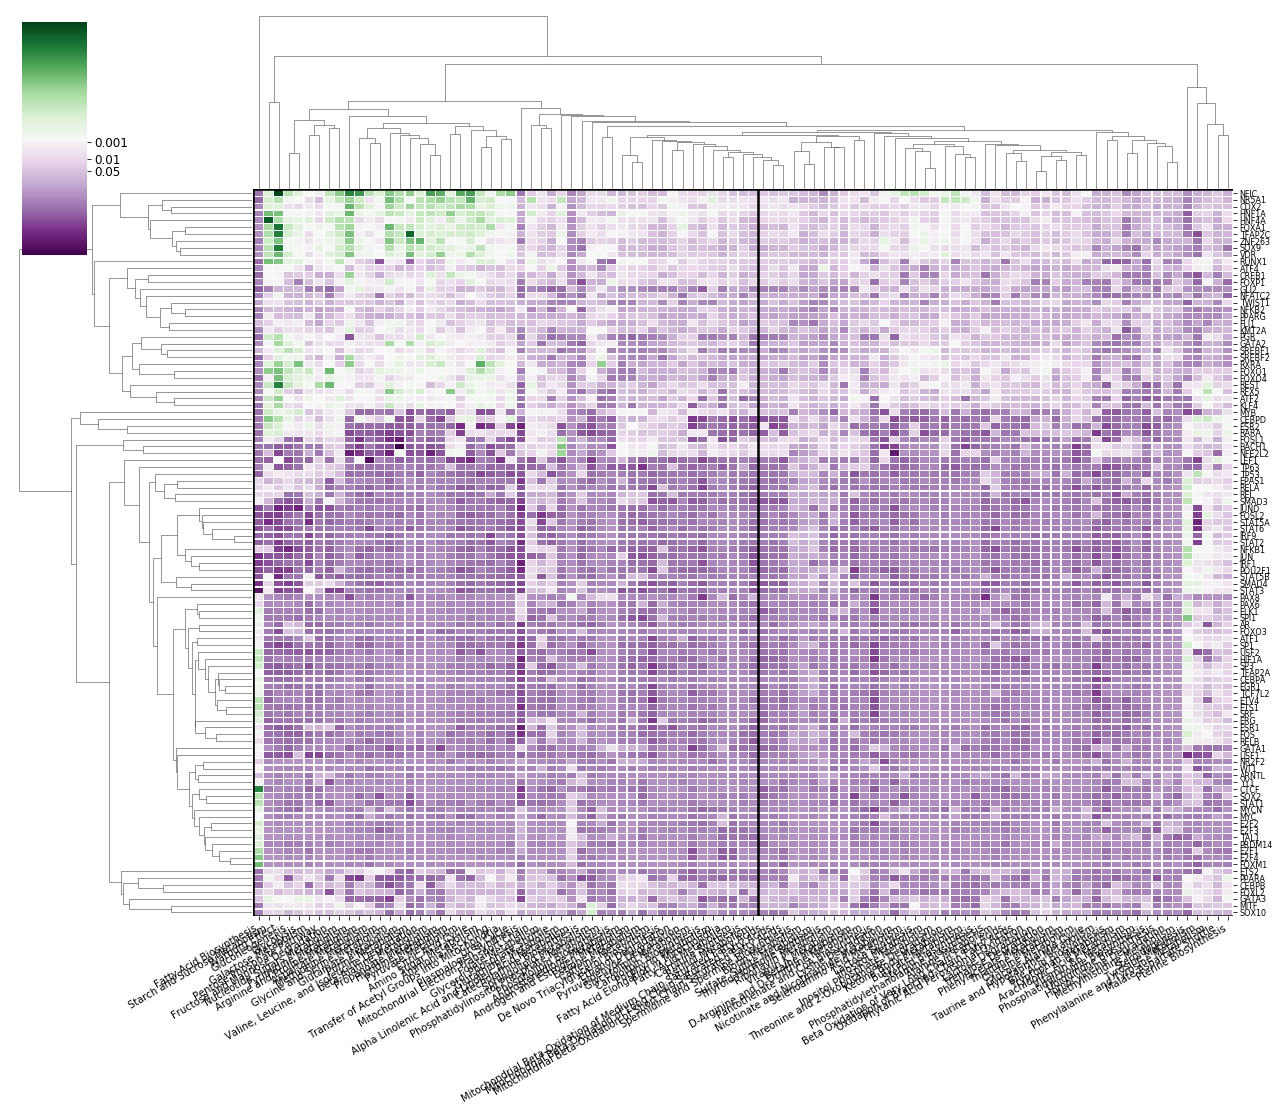

In [58]:
g = sns.clustermap(complete_pathway_pvalues.transpose(), yticklabels = True, xticklabels = True, figsize = (18,18)
                   ,cmap = "PRGn",
               lw = 0.25, linecolor="#fbfbfb")

ax = g.ax_heatmap
ax.set_xlabel("")
ax.axhline(0, c="k", lw = 2.5)
ax.axvline(top_correlations.shape[0], c="k", lw = 2.5)
ax.axvline(0, c="k", lw = 2.5)
ax.axhline(top_correlations.shape[1], c="k", lw = 2.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation =30, ha = "right", size = 10)

ax.set_yticklabels(ax.get_yticklabels(), rotation =0, ha = "left", size = 8)

cbar = ax.collections[0].colorbar
cbar.set_ticks([-np.log10(0.05), -np.log10(0.01), -np.log10(0.001)])
cbar.set_ticklabels(['0.05', '0.01', '0.001'])
cbar.ax.tick_params(labelsize=12)
cbar.outline.set_visible(True)